In [144]:
import typing as tp
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

np.random.seed(seed=1)

# Analysis of OIPs

Notational cavil: Don't subscript your variables with variables. Just vary the first variable. It complicates the exposition to say $t_i$ instead of just $t$, where instead of $i$ varying, $t$ is allowed to vary. Because then you have things like $P_k$ being the price at time $t_k$, when you've already used $k$ for the funding rate, and now $t$ is suppressed because hey, why have two levels of subscripting? Exactly, don't. 

## OIP 1

The first concept is the 'time weighted average open interest long': $\mathrm{TWAOI}_{l}$, such that   'time weighted average open interest imbalance': $\mathrm{TWAOI}_{imb} = \mathrm{TWAOI}_{l} - \mathrm{TWAOI}_{s}$

In [94]:
def twa(series: tp.Iterable, period: float) -> float:
    return sum(series)/period

def display(series, period):    
    plt.plot(series,  marker='.')
    plt.show()
    print(f'TWA = {twa(series, period)}')

Say our period for the time weighting is $T$. We could have a situation like this: 

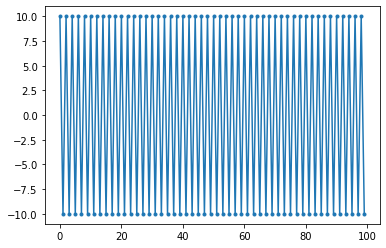

TWA = 0.0


In [96]:
T = 100
S = [10*(-1)**i for i in range(T)]
display(S, T)

Is this a problem? Does the time-weighted-averaging eliminate gaming funding rates in certain ways? What is the right period to average over? Why are we time-averaging?

Now, for the funding payment. We have $\mathrm{FP}_i = k(t_{i-1}, t_i) \cdot \mathrm{TWAOI}_{imb}(t_i)$

Which means we could have a situation like this (setting $k=1$ for now): 

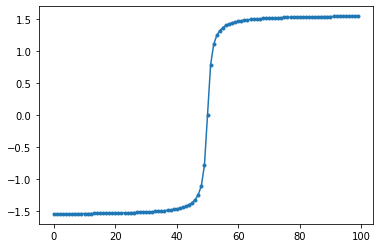

TWA = -0.015507989928217282


In [103]:
S = [np.arctan(x) for x in np.arange(-50,50,1)]
display(S, T)

Here, the imbalance is large to the long side, but the TWA is basically zero so there is no funding. However, this gets quite a bit worse:

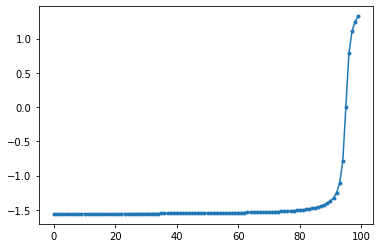

TWA = -1.3989745131855171


In [107]:
S = [np.arctan(x) for x in np.arange(-95,5,1)]
display(S, T)

Here, imbalance to the short side for a large period of time, which then shifts to the long side, results in a funding payment from the shorts to the longs! Moreover, the time-averaging has this funding last for awhile. 

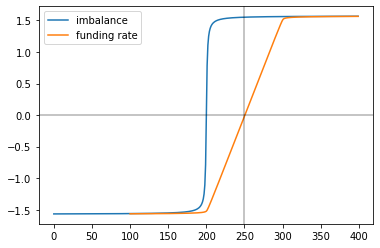

In [131]:
long_S = [np.arctan(x) for x in np.arange(-200,200,1)]
rolling_twa = [twa(long_S[i:100+i], T) for i in range(3*T)]
S = [np.arctan(x) for x in np.arange(-50,50,1)]
plt.plot(long_S, label='imbalance')
plt.plot([None]*100 + rolling_twa, label='funding rate')
plt.axvline(250, alpha=.3, c='k')
plt.axhline(0, alpha=.3, c='k')
plt.legend()

Here, the shorts are paying the longs (increasing the imbalance!) for roughly 50 time steps after the imabalance shifts to the longs. 

Again, why the time averaging? Can we not do everything instantaneously? Just measure the imbalance at each time step and sum over it? Or, if we cannot escape the need to time-average, can we do some weighting such that the past becomes less important? 

The time-averaging seems to also make things harder for arbitrageurs, because they can't just jump in when they see an imbalance. They need to know the entire past history of imbalances over the averaging period.

## Analysis of Portfolio Construction section

Note that this is a strong assumption of the foregoing analysis: 
>I take out a 1x short position on the OVL-ETH Overlay market, locking in the ETH value of my OVL collateral staked to first order in price changes given we use linear contracts.

If the OVL-ETH market is saturated with shorts, or has too much leverage, then the entire funding payment mechanism breaks. 

We discussed this in person.

The linear funding is probably best. It is simplest. I thought it might be an issue with the funding payment that 100% of the payment goes to offsetting position holders, regardless of the size of the offsetting position. The idea was that if competition between offsetters is low, then the mechanism will not work because with a very small amount of OVL I can collect all the funding. 

However, this is not right, because the offsetting position, when small, is growing rapidly via the funding payment. When large, it grows more slowly. 



In [236]:
def funding(longs, shorts):
    return (longs-shorts)

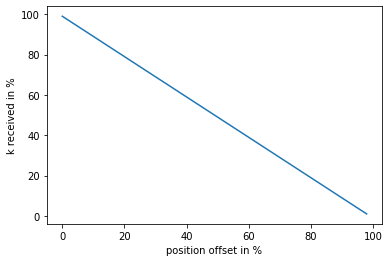

In [12]:
X = 100 #putative OVL amount long 
R = np.arange(1,X,1)
plt.plot(funding(X, R))
plt.ylabel('k received in %')
plt.xlabel('position offset in %')
plt.show()

The above shows the funding as a function (y axis is percentage of k, x is percentage of position offset). We can imagine a different mechanism with dropoff on both sides, not just one: 

In [34]:
def parabolic_funding(imbalance, offset_vol):
    return (-(imbalance - (offset_vol*2))**2 +imbalance**2)/imbalance

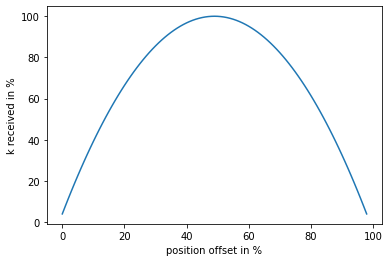

In [36]:
X = 100 #putative OVL amount long 
R = np.arange(1,X,1)
plt.plot(parabolic_funding(X, R))
plt.ylabel('k received in %')
plt.xlabel('position offset in %')
plt.show()

Instead of setting the floor for competition at .000001, this sets it higher -- possibly at half the imbalance. Can also introduce a skew to the right so funding falls to zero faster as offset approaches imbalance (imbalance goes to zero). For simplicity could nix the parabola and just make it linear, like an A frame.

How does the imbalance look over time, for a constant offsetting position just harvesting funding? 

In [122]:
def plot_imbalance(fcn=funding, k=.05, _X=100, offsets=[.001,.01, 1, 5,20,50]):

    res = defaultdict(list)
    for o in offsets:
        key = o
        X = _X
        ores = []
        Xres = []
        for t in range(100): #100 blocks
            ores.append(o)
            Xres.append(X)
            X -= k*fcn(X,o)
            o += k*fcn(X,o)
    
        plt.plot(Xres, c='r') #label=f'initial position {key}') 
        #plt.plot(ores, label=f'offsetting position {key}')
        plt.plot(np.array(Xres)-np.array(ores), c='k') #label=f'imbalance {key}')
    
    plt.title(f'k={k}, initial imbalance={_X} \n various initial offsets: {str(offsets)}')
    #plt.legend()
    plt.ylabel('OVL')
    plt.xlabel('time')
    plt.show()
    

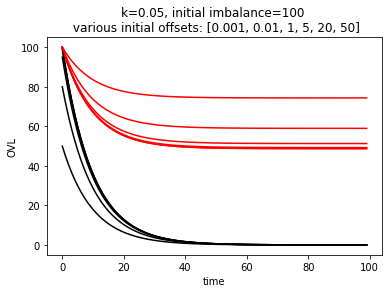

In [120]:
plot_imbalance()

This shows that the linear payments all have roughly the same result for the imbalance, but that the user experience for those CREATING the imbalance is a night and day difference between losing 20% and almost 50% to funding: DEPENDING ON THE INITIAL OFFSET CHOSEN BY THE ARBITRAGEURS.

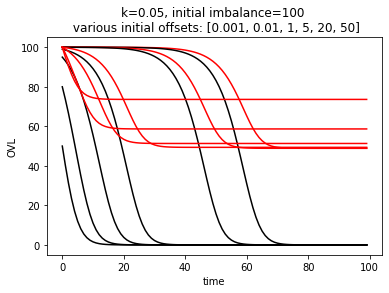

In [121]:
plot_imbalance(fcn=parabolic_funding)

The user experience for those creating the imbalance varies even more for parabolic funding, because of the possibility of a sudden dropoff. Also, the time required to achieve balance varies more.

If we are computing funding every block, the value k needs to depend PER MARKET on the oracle update time. Or, we could compute funding per oracle fetch, and have that be the heartbeat for balancing positions. This is important because if we update per block, slow oracles will result in massive funding differences between oracle fetches. 

In general, we want to avoid the situation where traders don't understand what is going on, or come back to their positions and they've incurred huge, mysterious losses. 

It seems like a good idea to have the funding mechanism kick in when the imbalance is GREATER than some amount, which is a tunable parameter depending on the risk to the system. 

The value of k determines how quickly money flows to the offsetting side. Setting this aggressively, we can very quickly siphon off our users' money. The below shows evolution for longs = 100, shorts = .01, with various values of k. 

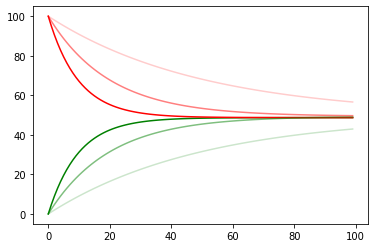

In [254]:
res = []

for k in [.05, .025, .01]:
    X = 100
    o = .01
    ores = []
    Xres = []
    for t in range(100): #100 blocks
        ores.append(o)
        Xres.append(X)
        X -= k*funding(X,o)
        o += k*funding(X,o)
    plt.plot(ores, c='g', alpha=k*20)
    plt.plot(Xres, c='r', alpha=k*20)
plt.show()

However, notice the drawdown for the longs in this case. They have lost 50% of their money to funding. Nobody who this happens to will come back. 

While k controls how quickly funding eliminates imbalance, the initial offsetting volume determines the equilibrium volumes. It may be advisable to set a minimum offsetting position size to gather funding. The above is the rational offsetting risk, (.01 OVL), but if we set the minimum to say 60% of the imbalance, the drawdown for longs is 20%. 


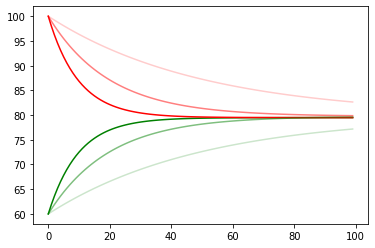

In [256]:
res = []

for k in [.05, .025, .01]:
    X = 100
    o = 60
    ores = []
    Xres = []
    for t in range(100): #100 blocks
        ores.append(o)
        Xres.append(X)
        X -= k*funding(X,o)
        o += k*funding(X,o)
    plt.plot(ores, c='g', alpha=k*20)
    plt.plot(Xres, c='r', alpha=k*20)
plt.show()

## Checking the math 

In [123]:
def PO(n, P_t, P):
    return n*(1 - (P_t- P)/P) 

In [138]:
x = 1
n = 1
assert PO(n, 2*x, x) == 0
assert PO(n, 2.0001*x, x) < 0
assert PO(n, x, x) == n
assert PO(n, .5*x, x) == 1.5*n
assert PO(n, .1*x, x) == 1.9*n
assert PO(n, 0, x) == 2*n

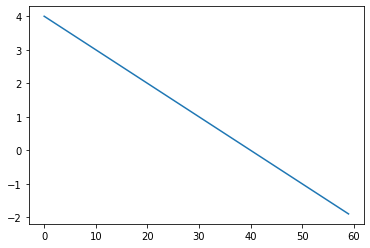

In [143]:
R = np.arange(x-3*x,x+3*x,.1) #we let the price go negative
plt.plot(PO(n, R, x))
plt.show()

In [147]:
P0 = sp.Symbol('P0')
Pt = sp.Symbol('Pt')
n = sp.Symbol('n')
S = sp.Symbol('S') #this is the SUM term of funding payments

eqn = Pt*n*(2 - (Pt/P0 + P0/Pt) + S)
eqn

Pt*n*(-P0/Pt + S + 2 - Pt/P0)

In [150]:
e = sp.Symbol('e')
eqn2 = eqn.subs(Pt, P0*(1+e))
eqn2

P0*n*(e + 1)*(S - e + 1 - 1/(e + 1))

In [152]:
eqn2.simplify().factor(S)

P0*n*(S*(e + 1) - e**2)

# Correct!

## the next section:

This crap is so fiddly and hard to think about I'm writing functions for everything

In [412]:
#    '''
#    px is the price of OVL-ETH, 
#    if it is > 1, OVL is more valuable than ETH
#    '''
def fromETH(amt, px):
    return amt/px
def fromOVL(amt, px):
    return amt*px

In [413]:
fromOVL(100, .15)

15.0

Say Px of ETH-OVL is .1 so there are 10 OVL in 1 ETH. Say I have 100 OVL (worth 10 ETH). I sell half the OVL for ETH, now I have 50 OVL and 5 ETH. I lock the OVL long to ETH. 

Two scenarios: px of ETH-OVL goes UP by 50% (so 6.66 OVL in an ETH) or down by 50%, so there are 20 OVL in 1 ETH.

In either case I have 5 ETH. 

In case 1: I have I have 50*1.5 = 75 OVL. The 5 ETH are worth 25 OVL, so I have 100 OVL

In case 2: I have 50*.5 = 25 OVL. But 5 ETH = 75 OVL, so still 100 OVL. 

In [477]:
def px_from_ret(px0, ret):
    '''get the new price given a return'''
    ret = ret/100
    return (ret + 1)*px0

def pnl(amt, ret):
    return amt * (1 + ret/100)

p0 = .1
N = 100

12.5

In [496]:
assert fromOVL(N/2, p0) == 5
assert fromETH(5, p0) == 50
assert fromETH(fromOVL(N, p0), p0) == N
assert fromOVL(fromETH(N, p0), p0) == N

assert np.isclose(px_from_ret(p0, 50), .15)
assert np.isclose(px_from_ret(p0, 200), .3)
assert np.isclose(px_from_ret(p0, -50), .05)

assert pnl(100, 50) == 150
assert pnl(100, -50) == 50

In [541]:
OVL0 = N/2
ETH0 = fromOVL(N/2, p0)
assert OVL0 + fromETH(ETH0, p0) == N

ret = 50
p1 = px_from_ret(p0, ret)
OVL1 = pnl(OVL0, ret)
assert OVL1 == 75
OVL2 = fromETH(ETH0, p1)
OVL1 + OVL2

def PO(N, p0, p1):
    return N * (1 + (p1 - p0)/p0)

assert PO(N/2, p0, p1) == OVL1

def ETH_PO(N, p0, p1):
    return N*(p0/p1)

assert np.isclose(ETH_PO(N/2, p0, p1), OVL2)

def V(N, p0, p1):
    return N*(p0/p1 + 1 + (p1-p0)/p0)


assert np.isclose(OVL1 + OVL2 ,V(N/2, p0, p1))

## Looks good!

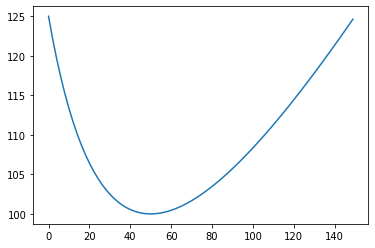

In [545]:
def get_portfolio_value_from_return(N, ret):
    OVL0 = N/2
    ETH0 = fromOVL(N/2, p0)
    p1 = px_from_ret(p0, ret)
    OVL1 = pnl(OVL0, ret)
    OVL2 = fromETH(ETH0, p1)
    return OVL1 + OVL2

RETS = np.arange(-50,100,1)

P = get_portfolio_value_from_return(N, RETS)

plt.plot(P)
plt.show()    

In [506]:
ret = 0
px = px_from_ret(p0, ret)

new_ovl = pnl(N/2, 50)
new_ovl_from_eth = fromETH(fromOVL(N/2, p0), px)

fromOVL(new_ovl + new_ovl_from_eth, px)

12.5

In [377]:
def value(P, P0, n=100):
    return (n/2)*(1 + (P - P0)/P0)

In [381]:
value(10, 5)

100.0

## some random scratch notes

Arbitraging is worthwhile so long as \\(S > e^2/(e+1) \\). Below we plot this for various values of \\( e\\), keeping in mind that the funding payments must be greater than these values for arbitrageurs to profit

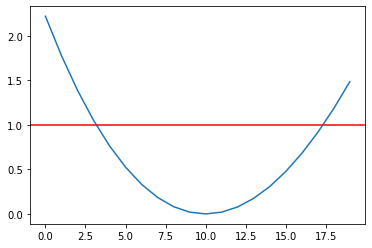

In [373]:
def f(a, e):
    return a*200*e**2/(e+1)
E = np.arange(-.10,.10,.01)
plt.plot(f(1, e=E))
plt.axhline(1, c='r')
#plt.xticks(ticks=range(len(E)))#, labels=(np.array(range(len(E)))-10)/10)
plt.show()

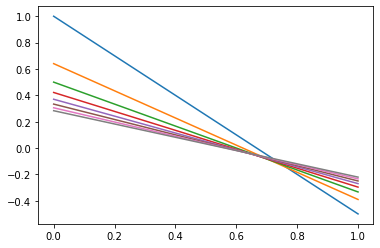

In [374]:
def get_e(a):
    A = 1
    B = np.sqrt(1 + 80*a)
    C = 40*a
    return (A+B)/C, (A-B)/C

alphas = np.arange(.1, .9, .1)
plt.plot(get_e(alphas))
plt.show()

In [375]:
get_e(.33)

(0.47231067661522425, -0.32079552510007275)

In [357]:
#def get_k(ell, m):
#    return (1 - ell**(1/m))/2

#make table 
#top = ['| pct ']
#for ell in np.arange(.1, .9, .1):
#    res=['|' + '%.1f' % ell]
#    for m in range(1,10):
#        #print(ell, m)
#        top.append('%.0f' % m)
#        res.append('%.3f' % get_k(ell, m))
#    if ell == .1 and m == 9:
#        print(' | '.join(top), '|')
#    print(' | '.join(res), '|')